<a href="https://colab.research.google.com/github/EmeraldMath/Tensorflow_models/blob/master/tf_keras_regression_model_hp_search_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

TensorFlow 2.x selected.
2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.17.5
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7) #default test_size = 0.25
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# RandomizedSearchCV
# 1. convert keras model into sklearn model
# 2. define the set of parameters
# 3. search hyperparameters with randomized search

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(30, activation='relu',
                          input_shape = x_train.shape[1:]))
    # add fully connected hidden layers with the input size of previous layer
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation='relu'))
    model.add(keras.layers.Dense(1)) 
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta = 1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 100,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 262us/sample - loss: 1.2097 - val_loss: 0.7051
Epoch 2/100
11610/11610 [==============================] - 1s 90us/sample - loss: 0.6091 - val_loss: 0.6235
Epoch 3/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.5451 - val_loss: 0.5620
Epoch 4/100
11610/11610 [==============================] - 1s 92us/sample - loss: 0.5204 - val_loss: 0.5330
Epoch 5/100
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5235 - val_loss: 0.5184
Epoch 6/100
11610/11610 [==============================] - 1s 98us/sample - loss: 0.4990 - val_loss: 0.4945
Epoch 7/100
11610/11610 [==============================] - 1s 94us/sample - loss: 0.4710 - val_loss: 0.4840
Epoch 8/100
11610/11610 [==============================] - 1s 89us/sample - loss: 0.4554 - val_loss: 0.4799
Epoch 9/100
11610/11610 [==============================] - 1s 90us/sample - loss: 0.44

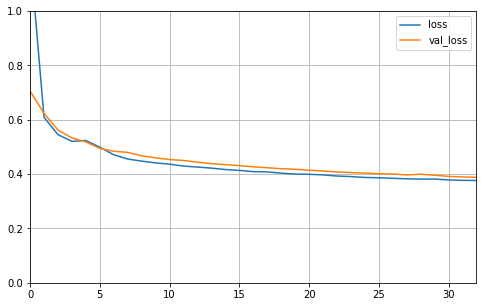

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [7]:
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2, size=10).tolist()
reciprocal(1e-4, 1e-2)

In [8]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    #"layer_size": [1, 10, 100],
    #"learning_rate": [1e-4, 1e-2]
    "layer_size": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal.rvs(1e-4, 1e-2, size=10).tolist()
}

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
# n_iterint, default=10: Number of parameter settings that are sampled.
# n_iter trades off runtime vs quality of the solution.
# cv = 5 by defult (cross validate)
# n_jobsint or None, optional (default=None): Number of jobs to run in parallel.
# None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
# See Glossary for more details.
random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      cv = 3,
                                      n_iter = 10,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)
# cross_validation: training data into n sets, n-1 for training for hp, 1 for validate
# the final lost is based on all n traing data

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 153us/sample - loss: 4.4286 - val_loss: 3.9796
Epoch 2/100
7740/7740 [==============================] - 1s 120us/sample - loss: 3.2314 - val_loss: 2.8086
Epoch 3/100
7740/7740 [==============================] - 1s 106us/sample - loss: 2.2786 - val_loss: 2.0072
Epoch 4/100
7740/7740 [==============================] - 1s 103us/sample - loss: 1.6957 - val_loss: 1.5653
Epoch 5/100
7740/7740 [==============================] - 1s 102us/sample - loss: 1.3881 - val_loss: 1.3339
Epoch 6/100
7740/7740 [==============================] - 1s 115us/sample - loss: 1.2215 - val_loss: 1.1975
Epoch 7/100
7740/7740 [==============================] - 1s 116us/sample - loss: 1.1139 - val_loss: 1.1027
Epoch 8/100
7740/7740 [==============================] - 1s 111us/sample - loss: 1.0343 - val_loss: 1.0301
Epoch 9/100
7740/7740 [==============================] - 1s 116us/sample - loss: 0.9715 - val_lo

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f89bd99cf28>,
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19, 20,
                                                       21, 22, 23, 24, 25, 26,
                                                       27, 28, 29, 30, ...],
                                        'learning_rate': [0.0005241509697928996,
                                                          0.00010374152447233374,
                                                          0.00015918406037185935,
                                                          0.00528111685177

In [9]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

{'learning_rate': 0.005281116851771535, 'layer_size': 64, 'hidden_layers': 3}
-0.34608055587784164
5160/5160 [==============================] - 0s 67us/sample - loss: 0.3390


0.3390093436536863